In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from enum import Enum

class Stage(Enum):
    CC_IN = 0
    CV_IN = 1
    IDLE_IN = 2
    CC_OUT = 3
    IDLE_OUT = 4

从excel中读取数据

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
capacity_file = './0/capacity.xlsx'
curve_file = './0/curve.xlsx'

df_capacity = pd.read_excel(capacity_file)
df_curve = pd.read_excel(curve_file)

d:\Miniconda3\envs\battery\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
df_capacity.head()

,Unnamed: 0,循环号,充电容量(Ah),放电容量(Ah),SOH(%)
0,CCCV 2.0A-1 1-10,1,0.9151,1.9870,100.000000
1,NaN,2,1.9840,1.9859,99.944640
2,NaN,3,1.9874,1.9861,99.954706
3,NaN,4,1.9884,1.9890,100.100654
4,NaN,5,1.9906,1.9917,100.236537


In [6]:
df_curve.head()

,Unnamed: 0,数据序号,循环号,工步类型,总时间(hh:mm:ss),电流(A),电压(V)
0,CCCV 2.0A-2 1-10,1,1,恒流充电,00:00:00,1.9997,3.7810
1,NaN,2,1,恒流充电,00:00:30,2.0001,3.8160
2,NaN,3,1,恒流充电,00:01:00,2.0002,3.8255
3,NaN,4,1,恒流充电,00:01:30,2.0001,3.8322
4,NaN,5,1,恒流充电,00:02:00,2.0002,3.8382


In [7]:
def map_stage_to_enum(stage, last_stage):
    if stage == "恒流充电":
        return Stage.CC_IN
    elif stage == "恒压充电":
        return Stage.CV_IN
    elif stage == "搁置" and (last_stage == Stage.CV_IN or last_stage == Stage.IDLE_IN):
        return Stage.IDLE_IN
    elif stage == "恒流放电":
        return Stage.CC_OUT
    elif stage == "搁置" and (last_stage == Stage.CC_OUT or last_stage == Stage.IDLE_OUT):
        return Stage.IDLE_OUT
    else:
        raise ValueError("Unknown stage")

准备 CURVES 和 LABELS

In [8]:
delta_t = 30  # seconds

CURVES = []

# item in data:
"""
item = {
    data: [[voltage, current], [voltage, current], ...],
    stages: [(idx, idx), (idx, idx), ...], # idx is the index of stage, [idx, idx]
}
"""

stage, last_stage = None, None
idx_start, idx_end = 0, -1
cycle_num, last_cycle_num = 1, None
data_list = []
stages = []

for i, row in df_curve.iterrows():
    idx_end += 1
    data = row[["电流(A)", "电压(V)"]].values.tolist()
    stage = map_stage_to_enum(row["工步类型"], last_stage)
    if last_stage is None:
        last_stage = stage
    if stage == last_stage:
        data_list.append(data)
        continue

    last_stage = stage
    stages.append((idx_start, idx_end))

    cycle_num = row["循环号"]
    if last_cycle_num is None:
        last_cycle_num = cycle_num

    if cycle_num == last_cycle_num:
        idx_start = idx_end
        data_list.append(data)
        continue

    curve = {
        "data": data_list,
        "stages": stages,
    }
    CURVES.append(curve)
    data_list = [data]
    stages = []
    idx_start, idx_end = 0, 0
    last_cycle_num = cycle_num

len(CURVES)

592

In [9]:
print(f"Total {len(CURVES)} curves")
print(f"第0条曲线包含{len(CURVES[0]['data'])}个数据点和{len(CURVES[0]['stages'])}个阶段")

Total 592 curves
第0条曲线包含237个数据点和5个阶段


In [10]:
LABELS = df_capacity['放电容量(Ah)'].values
len(LABELS)

584

In [11]:
if len(LABELS) != len(CURVES):
    num_data = min(len(LABELS), len(CURVES))
    LABELS = LABELS[:num_data]
    CURVES = CURVES[:num_data]
    
print(f"Total {len(CURVES)} curves")
print(f"Total {len(LABELS)} labels")

Total 584 curves
Total 584 labels


选择绘图的 style

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


for style in plt.style.available:
    print(style)


plt.style.use(style="seaborn-v0_8-talk")
sns.set_theme(style="darkgrid")

Solarize_Light2
_classic_test_patch
_mpl-gallery
_mpl-gallery-nogrid
bmh
classic
dark_background
fast
fivethirtyeight
ggplot
grayscale
seaborn-v0_8
seaborn-v0_8-bright
seaborn-v0_8-colorblind
seaborn-v0_8-dark
seaborn-v0_8-dark-palette
seaborn-v0_8-darkgrid
seaborn-v0_8-deep
seaborn-v0_8-muted
seaborn-v0_8-notebook
seaborn-v0_8-paper
seaborn-v0_8-pastel
seaborn-v0_8-poster
seaborn-v0_8-talk
seaborn-v0_8-ticks
seaborn-v0_8-white
seaborn-v0_8-whitegrid
tableau-colorblind10


绘制单个 cycle 的五阶段充放电曲线（电压和电流）

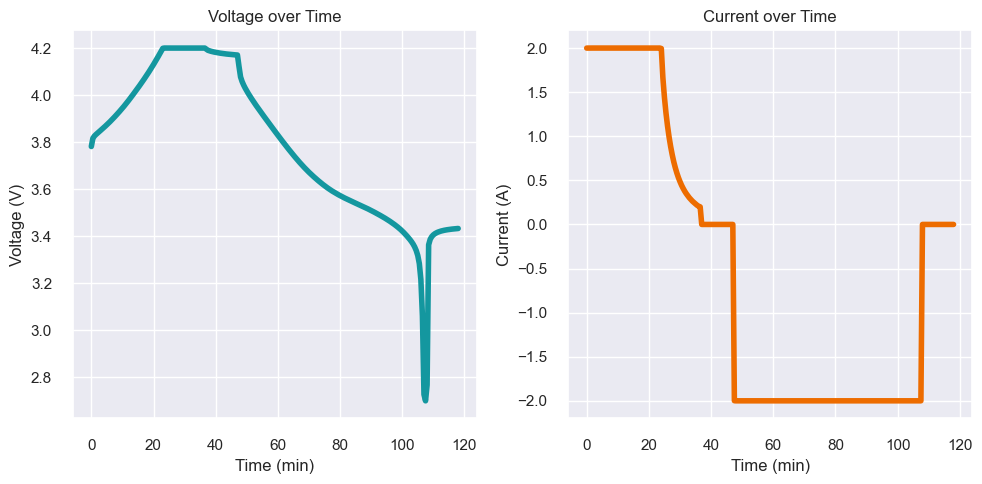

In [13]:
# 提取电压和电流数据
data = CURVES[0]["data"]
current_series = [d[0] for d in data]
voltage_series = [d[1] for d in data]
time_series = [e / 2 for e in range(len(data))]

# 绘制电压和电流曲线
plt.figure(figsize=(10, 5))

# 电压曲线
plt.subplot(1, 2, 1)
plt.plot(time_series, voltage_series, linestyle="-", color="#14979f", linewidth=4)
plt.title("Voltage over Time")
plt.xlabel("Time (min)")
plt.ylabel("Voltage (V)")

# 电流曲线
plt.subplot(1, 2, 2)
plt.plot(time_series, current_series, linestyle="-", color="#ed6c00", linewidth=4)
plt.title("Current over Time")
plt.xlabel("Time (min)")
plt.ylabel("Current (A)")

plt.tight_layout()
plt.show()

定义 CC 阶段的电压取样起止值和 CV 阶段的电流取样起止值

In [14]:
Vh = 4.2  # V
Vl = 4.0  # V

Ih = 2.0  # A
Il = 0.5  # A

In [15]:
def get_closest_idx(arr, target):
    return np.argmin(np.abs(arr - target))

CC-CV 充电阶段的电压和电流曲线

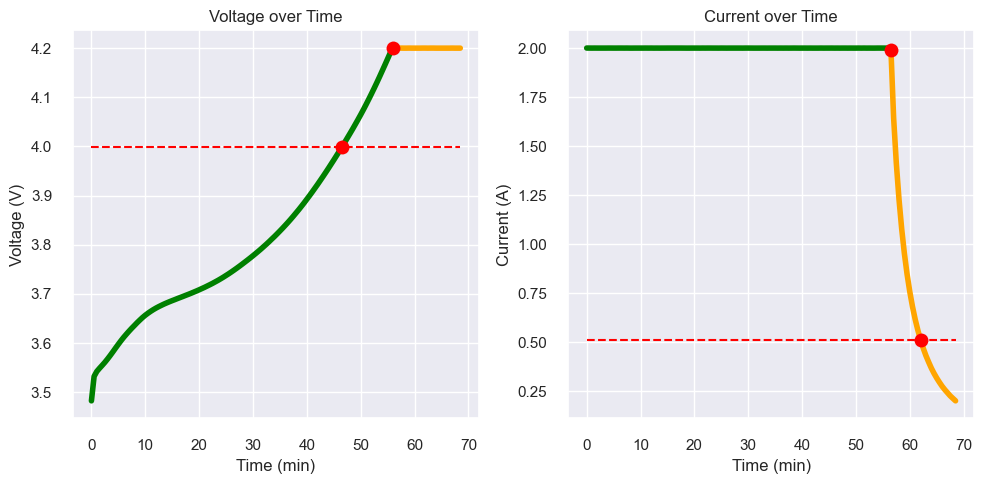

In [16]:
idx = 3

CC = CURVES[idx]["stages"][Stage.CC_IN.value]
CV = CURVES[idx]["stages"][Stage.CV_IN.value]
data_CC = CURVES[idx]["data"][CC[0] : CC[1]]
data_CV = CURVES[idx]["data"][CV[0] : CV[1]]

i_CC = [d[0] for d in data_CC]
v_CC = [d[1] for d in data_CC]
i_CV = [d[0] for d in data_CV]
v_CV = [d[1] for d in data_CV]
t_CC = [e / 2 for e in range(len(data_CC))]
t_CV = [e / 2 for e in range(len(data_CC), len(data_CC) + len(data_CV))]

idx_vh = -1
idx_vl = get_closest_idx(np.array(v_CC), Vl)
idx_ih = 0
idx_il = get_closest_idx(np.array(i_CV), Il)

# 绘制电压和电流曲线
plt.figure(figsize=(10, 5))

# 电压曲线
plt.subplot(1, 2, 1)
plt.plot(t_CC, v_CC, linestyle="-", linewidth=4, color="green")
plt.plot(t_CV, v_CV, linestyle="-", linewidth=4, color="orange")
plt.plot(t_CC[idx_vh], v_CC[idx_vh], marker="o", markersize=10, color="red")
plt.plot(t_CC[idx_vl], v_CC[idx_vl], marker="o", markersize=10, color="red")
plt.plot(
    t_CC + t_CV,
    [v_CC[idx_vl]] * len(t_CC + t_CV),
    label=f"y = {v_CC[idx_vl]}",
    linestyle="--",
    color="red",
)

plt.title("Voltage over Time")
plt.xlabel("Time (min)")
plt.ylabel("Voltage (V)")

# 电流曲线
plt.subplot(1, 2, 2)
plt.plot(t_CC, i_CC, linestyle="-", linewidth=4, color="green")
plt.plot(t_CV, i_CV, linestyle="-", linewidth=4, color="orange")
plt.plot(t_CV[idx_ih], i_CV[idx_ih], marker="o", markersize=10, color="red")
plt.plot(t_CV[idx_il], i_CV[idx_il], marker="o", markersize=10, color="red")
plt.plot(
    t_CC + t_CV,
    [i_CV[idx_il]] * len(t_CC + t_CV),
    label=f"y = {i_CV[idx_il]}",
    linestyle="--",
    color="red",
)
plt.title("Current over Time")
plt.xlabel("Time (min)")
plt.ylabel("Current (A)")

plt.tight_layout()
plt.show()

选择配色方案（sns的color_palette）

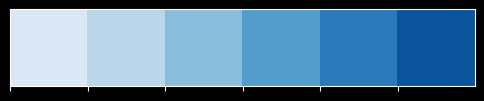

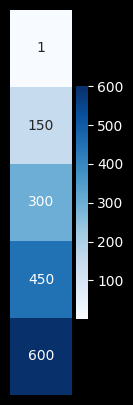

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

PALETTE = "Blues"
sns.palplot(sns.color_palette(PALETTE))
matrix = np.linspace(1, 600, 5).reshape(5, 1).astype(int)
fig = plt.figure(figsize=(1, 5))
sns_plot = sns.heatmap(
    matrix,
    annot=True,
    cmap=PALETTE,
    cbar=True,
    fmt=".0f",
    xticklabels=False,
    yticklabels=False,
)
plt.show()

绘制所有周期在选取区间内的电压和电流曲线：

电压曲线位于 CC 阶段

电流曲线位于 CV 阶段

249
[(0, 139)]
250
[(0, 24), (24, 45), (45, 163), (163, 184)]
259
[(0, 111)]
260
[(0, 24), (24, 45), (45, 163), (163, 184)]


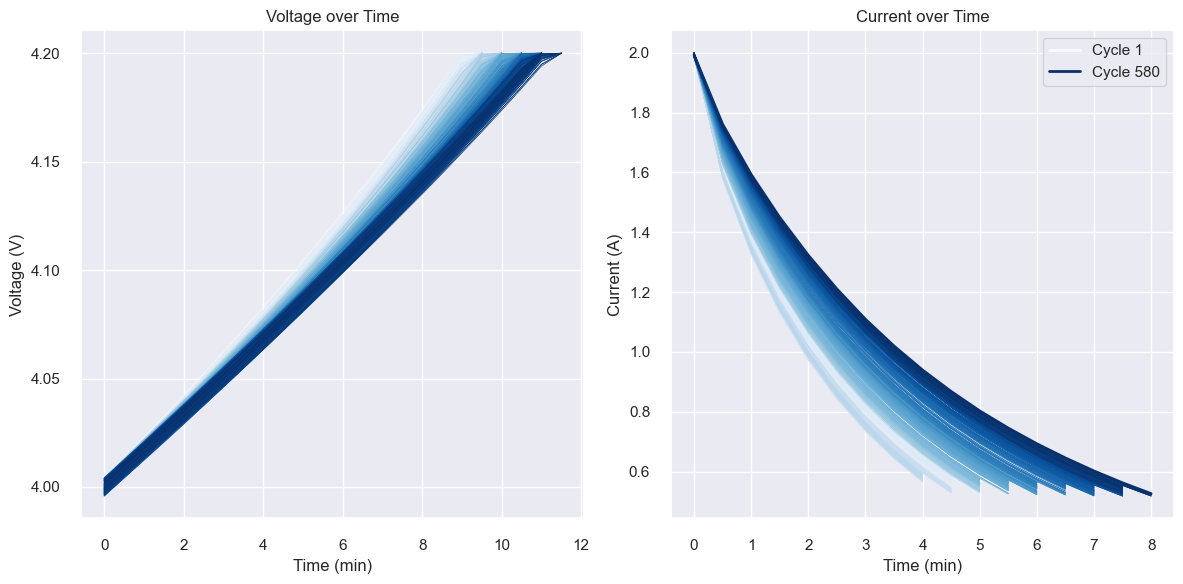

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

voltage_CC = []
current_CV = []
for index, curve in enumerate(CURVES):
    if len(curve["stages"]) < 5:
        print(index)
        print(curve["stages"])
        continue
    CC = curve["stages"][Stage.CC_IN.value]
    CV = curve["stages"][Stage.CV_IN.value]
    data_CC = curve["data"][CC[0] : CC[1]]
    data_CV = curve["data"][CV[0] : CV[1]]
    v_CC = [d[1] for d in data_CC]
    i_CV = [d[0] for d in data_CV]
    idx_vl = get_closest_idx(np.array(v_CC), Vl)
    idx_il = get_closest_idx(np.array(i_CV), Il)
    voltage_CC.append(v_CC[idx_vl:])
    current_CV.append(i_CV[:idx_il])


plt.figure(figsize=(12, 6))

# 绘制电压曲线
plt.subplot(1, 2, 1)
colors = sns.color_palette(PALETTE, n_colors=len(voltage_CC))
for idx, voltage in enumerate(voltage_CC):
    sns.lineplot(
        x=[t / 2 for t in range(len(voltage))],
        y=voltage,
        color=colors[idx],
        linewidth=0.5,
    )
plt.title("Voltage over Time")
plt.xlabel("Time (min)")
plt.ylabel("Voltage (V)")

# 绘制电流曲线
plt.subplot(1, 2, 2)
colors = sns.color_palette(
    PALETTE,
    n_colors=len(current_CV),
)
for idx, current in enumerate(current_CV):
    sns.lineplot(
        x=[t / 2 for t in range(len(current))],
        y=current,
        color=colors[idx],
        linewidth=0.5,
        label=(f"Cycle {idx+1}" if idx == 0 or idx == len(current_CV) - 1 else None),
    )

plt.title("Current over Time")
plt.xlabel("Time (min)")
plt.ylabel("Current (A)")

# 设置图例
handles, labels = plt.gca().get_legend_handles_labels()
for handle in handles:
    handle.set_linewidth(2)  # 设置线条的粗细为2
display_handles = [handles[0], handles[-1]]
display_labels = [labels[0], labels[-1]]
plt.legend(display_handles, display_labels)

plt.tight_layout()
plt.show()

获取指定区间内电压和电流样本的最小数量

手动指定电压和电流的数据量（大于最小数量的合适数量）

In [19]:
def get_min_num(curves, Vl, Il):
    min_num_v = 10000
    min_num_i = 10000
    for index, curve in enumerate(curves):
        if len(curve["stages"]) < 5:
            print(f"第{index+1}组数据不完整，跳过；它的stages是：")
            print(curve["stages"])
            continue
        CC = curve["stages"][Stage.CC_IN.value]
        CV = curve["stages"][Stage.CV_IN.value]
        data_CC = curve["data"][CC[0] : CC[1]]
        data_CV = curve["data"][CV[0] : CV[1]]
        v_CC = [d[1] for d in data_CC]
        i_CV = [d[0] for d in data_CV]
        idx_vl = get_closest_idx(np.array(v_CC), Vl)
        idx_il = get_closest_idx(np.array(i_CV), Il)
        min_num_v = min(min_num_v, len(v_CC[idx_vl:]))
        min_num_i = min(min_num_i, len(i_CV[:idx_il]))

    print("min_num_v:", min_num_v)
    print("min_num_i:", min_num_i)
    print("-" * 50)

get_min_num(CURVES, Vl, Il)

第250组数据不完整，跳过；它的stages是：
[(0, 139)]
第251组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
第260组数据不完整，跳过；它的stages是：
[(0, 111)]
第261组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
min_num_v: 20
min_num_i: 9
--------------------------------------------------


In [20]:
NUM_V = 20
NUM_I = 10

In [21]:
def get_training_data(curves, labels, num_v, num_i):
    """
    将数据转换为训练数据，截取相同长度的电压和电流数据
    电压数据来源于恒压充电阶段的末尾，电流数据来源于恒流放电阶段的开头
    """
    valid_labels = []
    voltage_CC = []
    current_CV = []
    for index, curve in enumerate(curves):
        if len(curve["stages"]) < 5:
            print(f"第{index+1}组数据不完整，跳过；它的stages是：")
            print(curve["stages"])
            continue
        valid_labels.append(labels[index])
        CC = curve["stages"][Stage.CC_IN.value]
        CV = curve["stages"][Stage.CV_IN.value]
        data_CC = curve["data"][CC[0] : CC[1]]
        data_CV = curve["data"][CV[0] : CV[1]]
        v_CC = [d[1] for d in data_CC]
        i_CV = [d[0] for d in data_CV]
        voltage_CC.append(v_CC[-num_v:])
        current_CV.append(i_CV[:num_i])

    print("-" * 50)

    return voltage_CC, current_CV, valid_labels

In [22]:
voltage_CC, current_CV, _ = get_training_data(CURVES, LABELS, NUM_V, NUM_I)

print(f"voltage_CC num: {len(voltage_CC)}, data length: {len(voltage_CC[0])}")
print(f"current_CV num: {len(current_CV)}, data length: {len(current_CV[0])}")

第250组数据不完整，跳过；它的stages是：
[(0, 139)]
第251组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
第260组数据不完整，跳过；它的stages是：
[(0, 111)]
第261组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
--------------------------------------------------
voltage_CC num: 580, data length: 20
current_CV num: 580, data length: 10


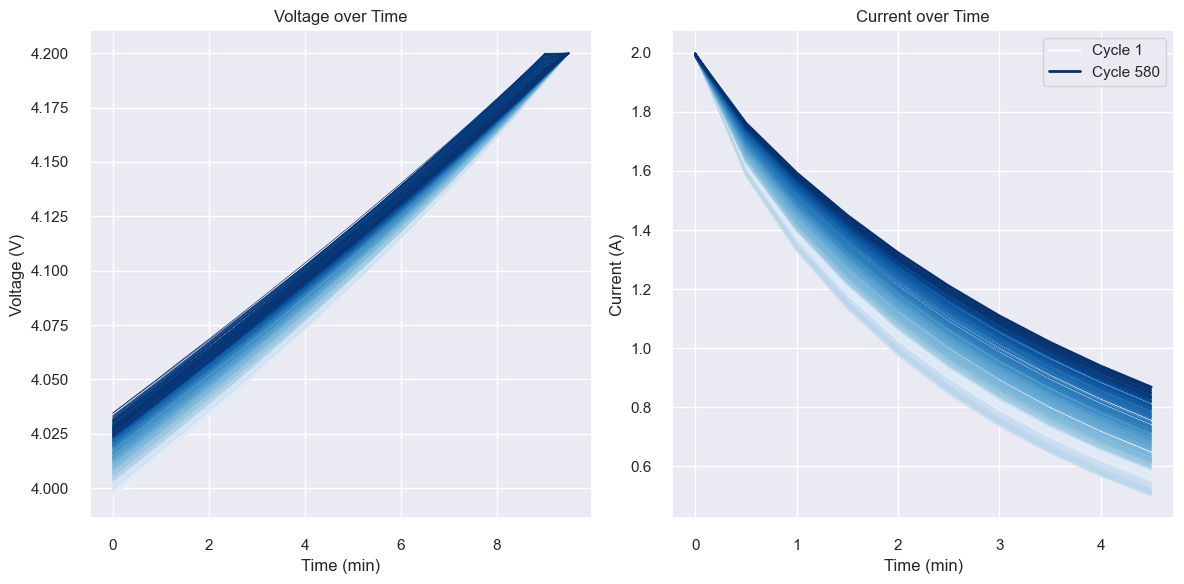

In [32]:
# 绘制电压曲线
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = sns.color_palette(PALETTE, n_colors=len(voltage_CC))
for idx, voltage in enumerate(voltage_CC):
    sns.lineplot(
        x=[t / 2 for t in range(len(voltage))],
        y=voltage,
        color=colors[idx],
        linewidth=0.5,
    )
plt.title("Voltage over Time")
plt.xlabel("Time (min)")
plt.ylabel("Voltage (V)")

# 绘制电流曲线
plt.subplot(1, 2, 2)
colors = sns.color_palette(
    PALETTE,
    n_colors=len(current_CV),
)
for idx, current in enumerate(current_CV):
    sns.lineplot(
        x=[t / 2 for t in range(len(current))],
        y=current,
        color=colors[idx],
        linewidth=0.5,
        label=(f"Cycle {idx+1}" if idx == 0 or idx == len(current_CV) - 1 else None),
    )

plt.title("Current over Time")
plt.xlabel("Time (min)")
plt.ylabel("Current (A)")

# 设置图例
handles, labels = plt.gca().get_legend_handles_labels()
for handle in handles:
    handle.set_linewidth(2)  # 设置线条的粗细为2
display_handles = [handles[0], handles[-1]]
display_labels = [labels[0], labels[-1]]
plt.legend(display_handles, display_labels)

plt.tight_layout()
plt.show()

In [26]:
data_X_v, data_X_i, data_y = get_training_data(CURVES, LABELS, NUM_V, NUM_I)

第250组数据不完整，跳过；它的stages是：
[(0, 139)]
第251组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
第260组数据不完整，跳过；它的stages是：
[(0, 111)]
第261组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
--------------------------------------------------


In [27]:
print(f"原始数量    -> {len(CURVES)}")
print(f"训练数量    -> 横流充电电压：{len(data_X_v)}，恒压充电电流：{len(data_X_i)}")
print(
    f"数据长度    -> 横流充电电压：{len(data_X_v[0])}，恒压充电电流：{len(data_X_i[0])}"
)
print(f"采样间隔    -> {delta_t}s")
print(f"CC阶段电流  -> {Ih}A")
print(f"CC阶段电压  -> {Vl}-{Vh}V")
print(f"CV阶段电压  -> {4.2}V")
print(f"CV阶段电流  -> {Il}-{Il}A")

原始数量    -> 584
训练数量    -> 横流充电电压：580，恒压充电电流：580
数据长度    -> 横流充电电压：20，恒压充电电流：10
采样间隔    -> 30s
CC阶段电流  -> 2.0A
CC阶段电压  -> 4.0-4.2V
CV阶段电压  -> 4.2V
CV阶段电流  -> 0.5-0.5A


模型部分

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from battery_predictor import BatteryPredictor
from battery_dataset import BatteryDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [29]:
X = torch.concatenate([torch.tensor(data_X_v), torch.tensor(data_X_i)], dim=1).to(device)
y = torch.tensor(data_y).to(device)
print(X.shape, y.shape)

torch.Size([580, 30]) torch.Size([580])


In [582]:
BATCH_SIZE = 16
EPOCHS = 50

In [583]:
from torch.utils.data import DataLoader

dataset = BatteryDataset(X, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [584]:
# 将训练集分为训练集和验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [585]:
predictor = BatteryPredictor(input_len=X.shape[1]).to(device)

模型训练

In [586]:
from tqdm import tqdm

predictor.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(predictor.parameters(), lr=0.001)

loss_list = []

for epoch in range(EPOCHS):
    tqdm_dataloader = tqdm(
        train_dataloader, desc=f"Epoch {epoch+1}", position=0, leave=True
    )
    for batch_X, batch_y in tqdm_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X.float())

        loss = criterion(output, batch_y.float().unsqueeze(1))
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tqdm_dataloader.set_postfix(loss=loss.item())

print("训练完成")

Epoch 50: 100%|██████████| 30/30 [00:00<00:00, 171.56it/s, loss=6.51e-5] 

训练完成


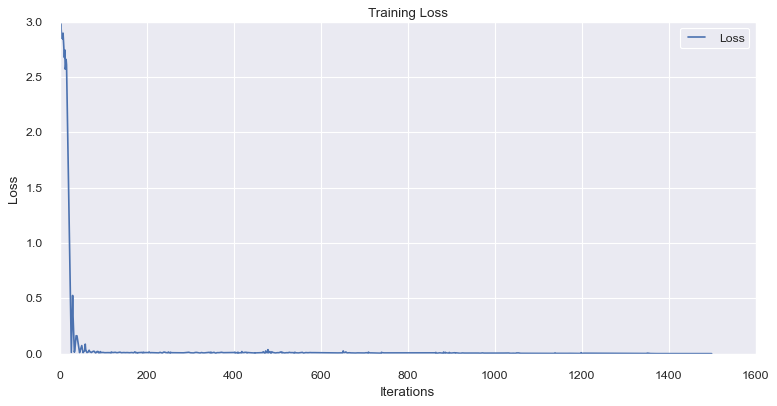

In [587]:
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label="Loss")
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

模型评估

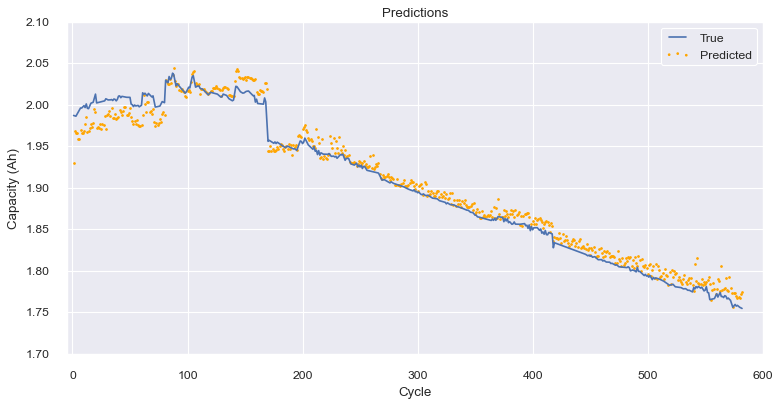

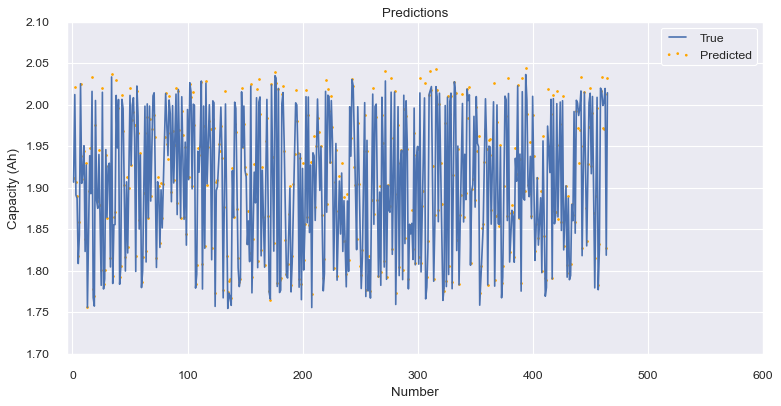

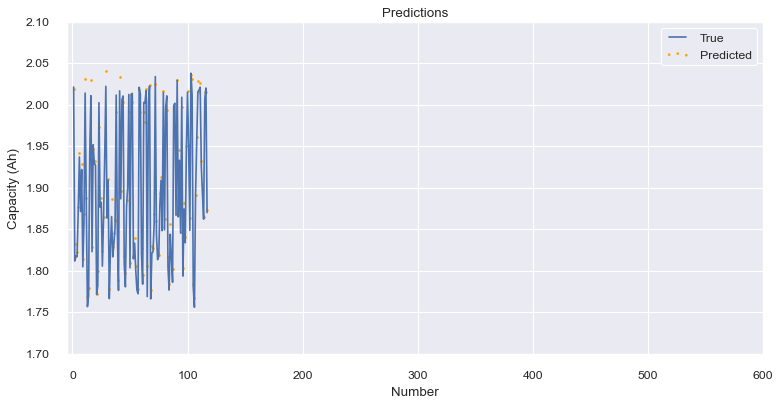

In [588]:
predictor.eval()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_predictions_X(predictor, X, y):
    with torch.no_grad():
        y_pred = predictor(X.float()).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, len(y) + 1)), y, label="True")
    plt.scatter(
        list(range(1, len(y_pred) + 1)), y_pred, label="Predicted", color="orange", s=2
    )
    plt.title("Predictions")
    plt.xlabel("Cycle")
    plt.ylabel("Capacity (Ah)")
    plt.legend()
    plt.xlim(-5, 600)
    plt.show()


def plot_predictions_dataloader(predictor, dataloader, device):
    y, y_pred = [], []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = predictor(batch_X.float())
            y.extend(batch_y.cpu().numpy())
            y_pred.extend(output.cpu().numpy())

    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, len(y)+1)), y, label="True")
    plt.scatter(list(range(1, len(y_pred)+1)), y_pred, label="Predicted", color="orange", s=2)
    plt.title("Predictions")
    plt.xlabel("Number")
    plt.ylabel("Capacity (Ah)")
    plt.legend()
    plt.xlim(-5, 600)
    plt.show()


plot_predictions_X(predictor, X, y)

plot_predictions_dataloader(predictor, train_dataloader, device)
plot_predictions_dataloader(predictor, val_dataloader, device)

In [589]:
# calculate the training error
y_true, y_pred = np.array([]), np.array([])
with torch.no_grad():
    for batch_X, batch_y in train_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X.float())
        y_true = np.append(y_true, batch_y.cpu().numpy())
        y_pred = np.append(y_pred, output.cpu().numpy())

error = np.abs(y_pred - y_true)
print(f"训练集 Mean error: {error.mean():.5f} Ah")

# calculate the validation error
y_true, y_pred = np.array([]), np.array([])
with torch.no_grad():
    for batch_X, batch_y in val_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X.float())
        y_true = np.append(y_true, batch_y.cpu().numpy())
        y_pred = np.append(y_pred, output.cpu().numpy())

error = np.abs(y_pred - y_true)
print(f"验证集 Mean error: {error.mean():.5f} Ah")

训练集 Mean error: 0.01037 Ah
验证集 Mean error: 0.00950 Ah


保存模型

In [590]:
path = "./battery_predictor.pth"
torch.save(predictor.state_dict(), path)
print(f"模型已保存到 {path}")

模型已保存到 ./battery_predictor.pth


读取模型

In [48]:
path = "./battery_predictor.pth"
predictor = BatteryPredictor(input_len=X.shape[1]).to(device)
predictor.load_state_dict(torch.load(path))

<All keys matched successfully>

验证模型

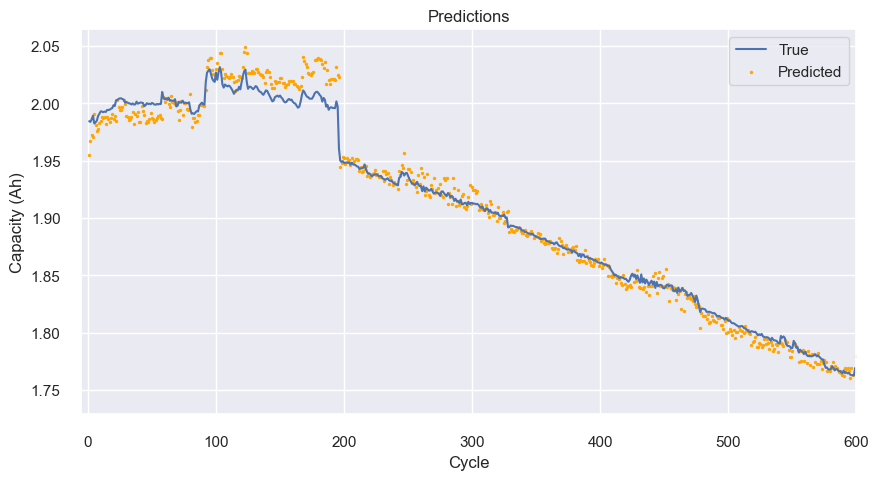

In [49]:
predictor.eval()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_predictions_X(predictor, X, y):
    with torch.no_grad():
        y_pred = predictor(X.float()).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, len(y) + 1)), y, label="True")
    plt.scatter(
        list(range(1, len(y_pred) + 1)), y_pred, label="Predicted", color="orange", s=2
    )
    plt.title("Predictions")
    plt.xlabel("Cycle")
    plt.ylabel("Capacity (Ah)")
    plt.legend()
    plt.show()


plot_predictions_X(predictor, X, y)

# calculate the validation error
y_true, y_pred = np.array([]), np.array([])
with torch.no_grad():
    for batch_X, batch_y in val_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X.float())
        y_true = np.append(y_true, batch_y.cpu().numpy())
        y_pred = np.append(y_pred, output.cpu().numpy())

error = np.abs(y_pred - y_true)
print(f"验证集 Mean error: {error.mean():.5f} Ah")